In [2]:
import numpy as np
import numpy.linalg
import csv
from tensorflow.keras import backend
from tensorflow.keras.callbacks import ReduceLROnPlateau
import itertools
import pandas as pd
from matplotlib import pyplot as plt
import math
from scipy import spatial
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import  matplotlib.pyplot as plt
from scipy.interpolate import BivariateSpline
import tensorflow as tf
from tensorflow import keras
from scipy.stats import pearsonr
import scipy.stats as st
import matplotlib.image as mpimg
from scipy import *
from openpyxl.drawing.image import Image
from scipy.interpolate import RegularGridInterpolator
from IPython.display import Image
import scipy as scipy
import subprocess
import matplotlib
import ctypes
import clr
from fastapi import APIRouter
import os
import io
import seaborn as sns
import json
from pandas import json_normalize
import requests

In [24]:
sFile = './mappedDataNew.csv'
data = pd.read_csv(sFile,sep=',').values

data[:, 12] = np.round(data[:,12].astype(float),2)
data[:, 8] = np.round(data[:,8].astype(float),2)
##knots to m/s
wfS = data[:, 11].astype(float) / (1.944)
data[:, 11] = np.round(wfS,2)

#lt/min => MT/day
data[:, 15] = ((data[:, 15]) / 1000)* 1440
##Build training data array

trData = np.array(np.append(data[:,8].reshape(-1,1),np.asmatrix([data[:,10],data[:,11],data[:,12],data[:,22],(data[:,15]),data[:,26],data[:,27],data[:,0]]).T,axis=1))#.astype(float)#data[:,26],data[:,27]
trData = np.array([k for k in trData if   float(k[2])>=0 and float(k[4])>=0 and float(k[3])>7 and float(k[5])>0  ])

trData[:,8] = list(map(lambda s: s[:-3], trData[:,8]))
d = {'draft': trData[:,0], 'wd': trData[:,1],'ws':trData[:,2],'stw':trData[:,3],'swh':trData[:,4],
     'foc':(trData[:,5]),'lat':trData[:,6],'lon':trData[:,7],'timestamp':trData[:,8] }
df  = pd.DataFrame(d)
print(trData.shape)
df.head(15)

(184088, 9)


,draft,wd,ws,stw,swh,foc,lat,lon,timestamp
0,7.64,188.96,20.45,7.14,1.19,40.32,54.0368,7.52468,2019-09-11 15:44
1,7.48,186.85,20.45,8.14,1.19,38.88,54.0343,7.52379,2019-09-11 15:45
2,7.49,174.55,23.02,8.14,1.19,70.56,54.0343,7.52379,2019-09-11 15:46
3,7.52,161.51,26.62,9.51,1.19,72,54.0312,7.52232,2019-09-11 15:47
4,7.81,139.12,23.92,10.11,1.19,70.56,54.0282,7.51965,2019-09-11 15:48
5,7.81,128.7,25.59,10.11,1.19,66.24,54.0255,7.5155,2019-09-11 15:49
6,7.22,124.34,25.59,10.11,1.19,64.8,54.0228,7.51057,2019-09-11 15:50
7,7.36,124.14,25.08,11.48,1.19,64.8,54.0228,7.51057,2019-09-11 15:51
8,7.38,111.62,23.41,11.66,1.19,57.6,54.0204,7.50503,2019-09-11 15:52
9,7.75,95.27,26.24,11.62,1.1,53.28,54.0185,7.499,2019-09-11 15:53


In [27]:
dfNew = df.iloc[:, : 6]
trData = dfNew.values
dfNew.head(15)

,draft,wd,ws,stw,swh,foc
0,7.64,188.96,20.45,7.14,1.19,40.32
1,7.48,186.85,20.45,8.14,1.19,38.88
2,7.49,174.55,23.02,8.14,1.19,70.56
3,7.52,161.51,26.62,9.51,1.19,72
4,7.81,139.12,23.92,10.11,1.19,70.56
5,7.81,128.7,25.59,10.11,1.19,66.24
6,7.22,124.34,25.59,10.11,1.19,64.8
7,7.36,124.14,25.08,11.48,1.19,64.8
8,7.38,111.62,23.41,11.66,1.19,57.6
9,7.75,95.27,26.24,11.62,1.1,53.28


In [33]:
router = APIRouter()
@router.get("/")
async def get_ModelComparison(interpolation):
    response = requests.get("https://localhost:5001/CompareConsumptionModels/?interpolation="+interpolation,verify=False)
    return response.text

modelComp = await get_ModelComparison("false")
json_dict = json.load(io.StringIO(modelComp))
df1 = pd.concat([pd.DataFrame(json_dict)])
print("Without Interpolation:")
df1



Without Interpolation:


/home/dimitris/.local/lib/python3.6/site-packages/urllib3/connectionpool.py:988: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


,speed,size,neuralDT_Acc,statsDT_Acc,actual_Avg,neuralDT_Avg,stats_Avg,neuralDT_RMSE,stats_RMSE
0,9.0,14,0.127678,0.344228,18.204286,20.528571,24.470714,0.005378,0.006994
1,9.5,5,-0.325672,-0.020460,30.890000,20.830000,30.258000,0.007512,0.002888
2,10.0,6,-0.317497,0.082381,32.976667,22.506667,35.693333,0.010069,0.007731
3,10.5,8,-0.304095,0.045861,38.676250,26.915000,40.450000,0.013203,0.010494
4,11.0,11,-0.126266,0.073659,41.542727,36.297273,44.602727,0.008067,0.007967
5,11.5,12,-0.162576,-0.029814,49.166667,41.173333,47.700833,0.010756,0.009814
6,12.0,24,-0.070862,0.037798,48.415833,44.985000,50.245833,0.006224,0.005807
7,12.5,83,-0.017550,0.113463,46.668675,45.849639,51.963855,0.001779,0.003974
8,13.0,120,-0.025999,0.127465,46.379333,45.173500,52.291083,0.002513,0.004748
9,13.5,531,0.001768,0.201601,43.343164,43.419793,52.081205,0.002588,0.006582


In [5]:
modelComp = await get_ModelComparison("true")
json_dict = json.load(io.StringIO(modelComp))
df = pd.concat([pd.DataFrame(json_dict)])
print("With Interpolation:")
df

With Interpolation:


/home/dimitris/.local/lib/python3.6/site-packages/urllib3/connectionpool.py:988: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


,speed,size,neuralDT_Acc,statsDT_Acc,actual_Avg,neuralDT_Avg,stats_Avg,neuralDT_RMSE,stats_RMSE
0,9.0,14,0.128121,0.349747,18.204286,20.536628,24.571175,0.005368,0.006908
1,9.5,5,-0.333968,-0.064016,30.890000,20.573741,28.912532,0.007693,0.003482
2,10.0,6,-0.329756,0.043868,32.976667,22.102424,34.423273,0.010204,0.007217
3,10.5,8,-0.308320,0.030309,38.676250,26.751574,39.848480,0.013249,0.010457
4,11.0,11,-0.122401,0.077127,41.542727,36.457839,44.746793,0.007927,0.007843
5,11.5,12,-0.152897,-0.023561,49.166667,41.649242,48.008269,0.010836,0.009926
6,12.0,24,-0.068946,0.041295,48.415833,45.077744,50.415169,0.006076,0.005783
7,12.5,83,-0.023047,0.113170,46.668675,45.593124,51.950184,0.001911,0.003976
8,13.0,120,-0.027624,0.125191,46.379333,45.098156,52.185587,0.002552,0.004684
9,13.5,531,-0.000428,0.198728,43.343164,43.324618,51.956670,0.002566,0.006498


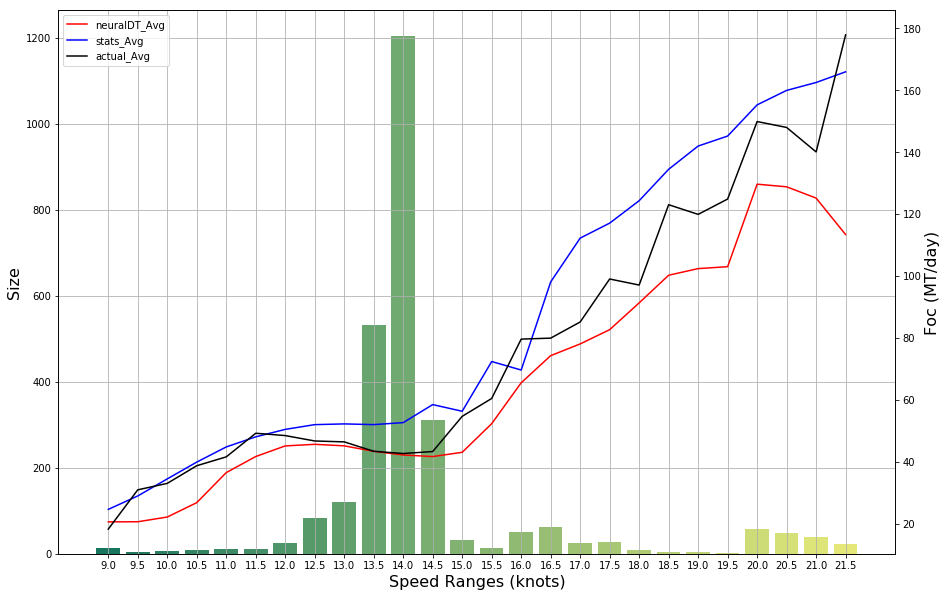

In [6]:
#Plot model performance

df['speed']= [str(k) for k in df['speed'].values]


def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)


#print(df.dtypes)

#sns.set(font_scale=1) 
fig, ax1 = plt.subplots(figsize=(15,10))
color = 'tab:green'
#bar plot creation
y_pos = [0,1,5,8,9,11,12,13,14]
bars = df['size']
plt.xticks(y_pos, bars)

ax1 = sns.barplot(x='speed', y='size', data = df, palette='summer',ci="sd")
ax1.set_xlabel('Speed Ranges (knots)', fontsize=16)
ax1.set_ylabel('Size', fontsize=16)
#change_width(ax1, 1.5)
ax1.tick_params(axis='x')
ax1.set_xticks(np.arange(9, 21.5, step=15.2))
ax1.grid()
#specify we want to share the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
#line plot creation
#ax2.set_ylabel('', fontsize=16)

ax2 = sns.lineplot(x='speed', y='neuralDT_Avg', data = df, sort=False, color='red',label='neuralDT_Avg')
ax2 = sns.lineplot(x='speed', y='stats_Avg', data = df, sort=False, color='blue',label='stats_Avg')
ax2 = sns.lineplot(x='speed', y='actual_Avg', data = df, sort=False, color='black',label='actual_Avg')
ax2.set_ylabel('Foc (MT/day)', fontsize=16)
ax2.grid()


plt.legend()
plt.grid()
plt.show()

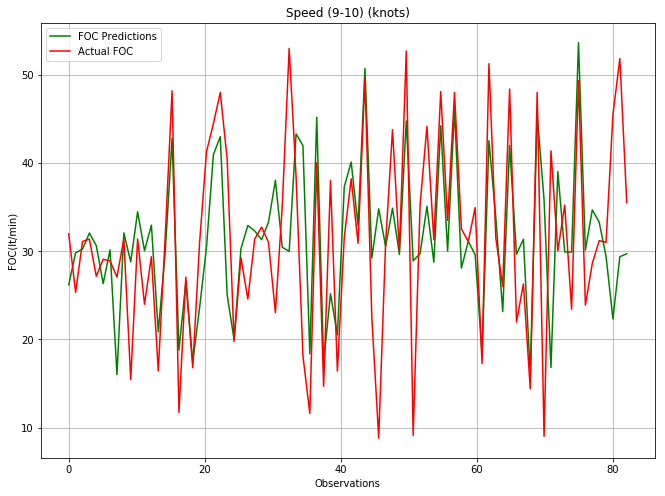

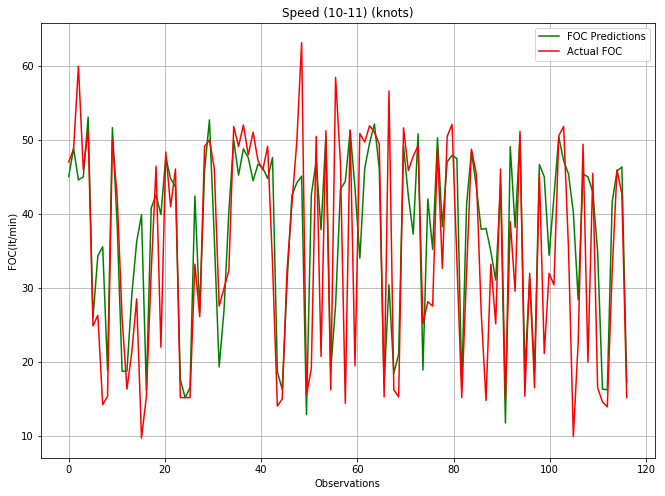

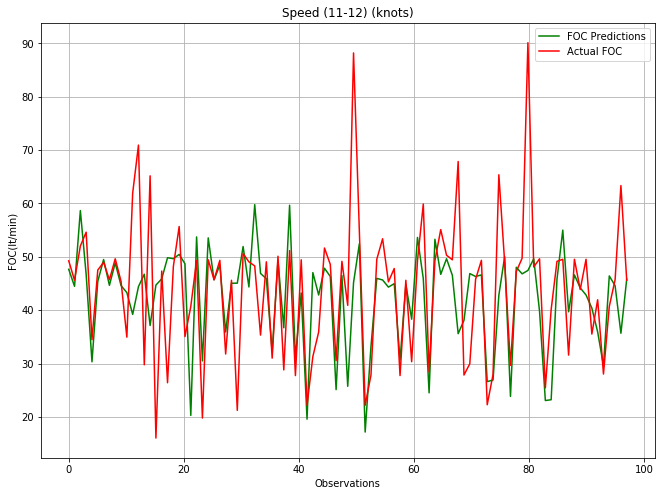

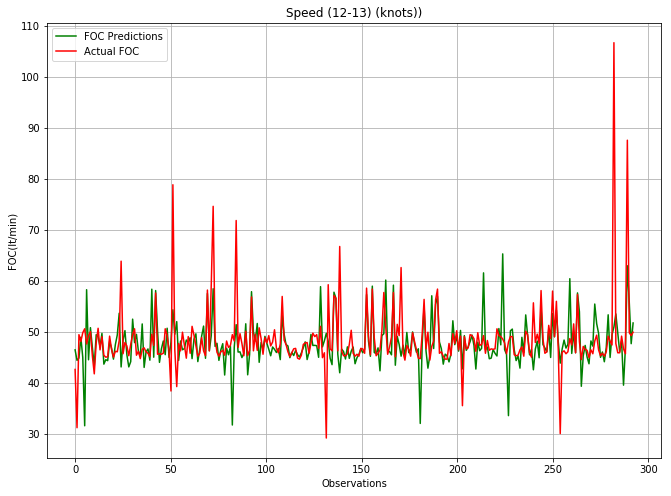

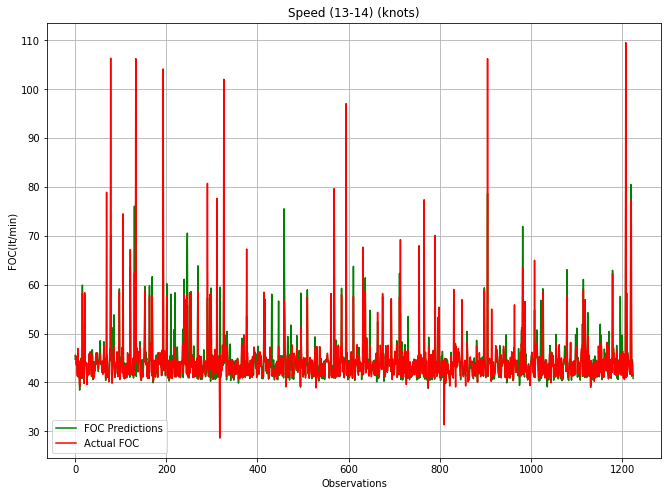

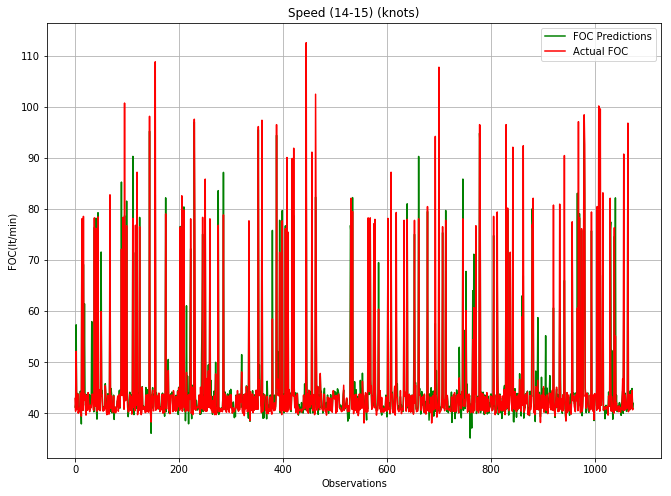

In [4]:
def PlotTrueVsPredLine():

        dataErrorFoc = pd.read_csv('./TESTerrorPercFOC1_0.csv', delimiter=',', skiprows=0)
        #dataErrorFocMA = pd.read_csv('C:/Users/dkaklis/Desktop/TESTerrorPercFOC2_0MA.csv', delimiter=',', skiprows=1)
        dataErr = dataErrorFoc.values
        #dataErrMA = dataErrorFocMA.values
        errMean = []
        errMeanMA = []
        focMean = []

        errMean020=[]
        focMean020=[]

        errMean2040 = []
        focMean2040 = []

        errMean4060=[]
        focMean4060 = []

        errMean6080 = []
        focMean6080 = []

        errMean80100 = []
        focMean80100 = []

        errMean100 = []
        focMean100 = []


        #df.to_csv('./AvgActualAvgPredSpeed.csv', index=False)
        #return
        i = 0
        size = 3500
        for i in range(0,len(dataErr)):
            #errMean.append(np.mean(dataErr[i:i + 20, 0]))
            errMean.append(dataErr[i,1])
            #errMeanMA.append(np.mean(dataErrMA[i:i + 20, 0]))
            focMean.append(dataErr[i, 2])

        for i in range(0, len(dataErr)):
                # errMean.append(np.mean(dataErr[i:i + 20, 0]))
            if dataErr[i,3] >9 and dataErr[i,3]<=10:
                    errMean020.append(dataErr[i, 0])
                    # errMeanMA.append(np.mean(dataErrMA[i:i + 20, 0]))
                    focMean020.append(dataErr[i, 1])

        for i in range(0, len(dataErr)):
            # errMean.append(np.mean(dataErr[i:i + 20, 0]))
            if dataErr[i,3] > 10 and dataErr[i,3] <= 11:
                errMean2040.append(dataErr[i, 0])
                # errMeanMA.append(np.mean(dataErrMA[i:i + 20, 0]))
                focMean2040.append(dataErr[i, 1])

        for i in range(0, len(dataErr)):
            # errMean.append(np.mean(dataErr[i:i + 20, 0]))
            if dataErr[i, 3] > 11 and dataErr[i, 3] <= 12:
                errMean4060.append(dataErr[i, 0])
                # errMeanMA.append(np.mean(dataErrMA[i:i + 20, 0]))
                focMean4060.append(dataErr[i, 1])

        for i in range(0, len(dataErr)):
            # errMean.append(np.mean(dataErr[i:i + 20, 0]))
            if dataErr[i, 3] > 12 and dataErr[i, 3] <= 13:
                errMean6080.append(dataErr[i, 0])
                # errMeanMA.append(np.mean(dataErrMA[i:i + 20, 0]))
                focMean6080.append(dataErr[i, 1])

        for i in range(0, len(dataErr)):
            # errMean.append(np.mean(dataErr[i:i + 20, 0]))
            if dataErr[i, 3] > 13 and dataErr[i, 3] <= 14:
                errMean80100.append(dataErr[i, 0])
                # errMeanMA.append(np.mean(dataErrMA[i:i + 20, 0]))
                focMean80100.append(dataErr[i, 1])

        for i in range(0, len(dataErr)):
            # errMean.append(np.mean(dataErr[i:i + 20, 0]))
            if dataErr[i, 3] >14 and dataErr[i, 3] <=15:
                errMean100.append(dataErr[i, 0])
                # errMeanMA.append(np.mean(dataErrMA[i:i + 20, 0]))
                focMean100.append(dataErr[i, 1])
                
                

        '''errMean = []
        errMeanMA = []
        focMean = []
        mae = []
        stwMean=[]
        draftMean=[]
        wsMean=[]
        #meanPercError = []
        i = 0
        while i < len(dataErr):
            errMean.append(np.mean(dataErr[i:i + 20, 0]))
            #errMeanMA.append(np.mean(dataErrMA[i:i + 20, 0]))
            #focMean.append(np.mean(dataErr[i:i + 20, 1]))
            meanPercError= dataErr[i, 2]
            if meanPercError > 50:
                stwMean.append(dataErr[i, 3])
                draftMean.append(dataErr[i, 4])
                wsMean.append(dataErr[i, 6])

            #stwMean.append(np.mean(dataErr[i:i + 20, 3]))
            #draftMean.append(np.mean(dataErr[i:i + 20, 4] ))
            #wsMean.append(np.mean(dataErr[i:i + 20, 6] ))
            mae.append(abs(np.mean(dataErr[i:i + 20, 1]) - np.mean(dataErr[i:i + 20, 0])))
            i = i + 1
            #i = i + 20

        errMean = np.array(errMean)
        errMeanMA = np.array(errMeanMA)
        focMean = np.array(focMean)

        features=[]
        values=[]
        groups=[]

        barWidth = 0.25
        r1 = np.arange(len(stwMean))
        r2 = [x + barWidth for x in r1]
        r3 = [x + barWidth for x in r2]

        # Make the plot
        plt.bar(r1, stwMean, color='#7f6d5f', width=barWidth, edgecolor='white', label='stw')
        plt.bar(r2, wsMean, color='#557f2d', width=barWidth, edgecolor='white', label='ws')
        plt.bar(r3, draftMean, color='#2d7f5e', width=barWidth, edgecolor='white', label='draft')

        # Add xticks on the middle of the group bars
        for i in range(0,len(stwMean)):
            groups.append( str(i))
        plt.xlabel('group', fontweight='bold')
        plt.xticks([r + barWidth for r in range(len(stwMean))], groups)

        #for i in range(0,len(stwMean)):
            #features.append(['stw'+str(i), 'draft'+str(i), 'ws'+str(i)])
            #values.append([int(stwMean[i]),int(draftMean[i]),int(wsMean[i])])
            #values = [stwMean, draftMean, wsMean]
            #plt.bar(features, values)


        # Create legend & Show graphic
        plt.legend()
        plt.figure(figsize=(3, 4))
        plt.show()'''
        fig, ax1 = plt.subplots(figsize=(11,8))
        fig, ax2 = plt.subplots(figsize=(11,8))
        fig, ax3 = plt.subplots(figsize=(11,8))
        fig, ax4 = plt.subplots(figsize=(11,8))
        fig, ax5 = plt.subplots(figsize=(11,8))
        fig, ax6 = plt.subplots(figsize=(11,8))
        #fig, (ax1, ax2, ax3,) = plt.subplots( 3)
        
        #fig.suptitle('FOC ')
        ax1.plot(np.linspace(0, len(errMean020),len(errMean020)), errMean020, '-', c='green', label='FOC Predictions')
        ax1.plot(np.linspace(0, len(focMean020), len(focMean020)), focMean020, '-', c='red', label='Actual FOC')
        ax1.title.set_text("Speed (9-10) (knots)")
        ax1.set_ylabel('FOC(lt/min)')
        ax1.set_xlabel('Observations')
        ax1.legend()
        ax1.grid()

        ax2.title.set_text("Speed (10-11) (knots)")
        ax2.plot(np.linspace(0, len(errMean2040), len(errMean2040)), errMean2040, '-', c='green', label='FOC Predictions')
        ax2.plot(np.linspace(0, len(focMean2040), len(focMean2040)), focMean2040, '-', c='red', label='Actual FOC')
        ax2.set_ylabel('FOC(lt/min)')
        ax2.set_xlabel('Observations')
        ax2.legend()
        ax2.grid()

        ax3.title.set_text("Speed (11-12) (knots)")
        ax3.plot(np.linspace(0, len(errMean4060), len(errMean4060)), errMean4060, '-', c='green',
                 label='FOC Predictions')
        ax3.plot(np.linspace(0, len(focMean4060), len(focMean4060)), focMean4060, '-', c='red', label='Actual FOC')
        ax3.grid()
        ax3.legend()
        ax3.set_ylabel('FOC(lt/min)')
        ax3.set_xlabel('Observations')
        

        #fig, (ax4,ax5,ax6) = plt.subplots(3)
        ax4.title.set_text("Speed (12-13) (knots))")
        ax4.plot(np.linspace(0, len(errMean6080), len(errMean6080)), errMean6080, '-', c='green',
                 label='FOC Predictions')
        ax4.plot(np.linspace(0, len(focMean6080), len(focMean6080)), focMean6080, '-', c='red', label='Actual FOC')
        ax4.set_ylabel('FOC(lt/min)')
        ax4.set_xlabel('Observations')
        ax4.legend()
        ax4.grid()

        ax5.title.set_text("Speed (13-14) (knots)")
        ax5.plot(np.linspace(0, len(errMean80100), len(errMean80100)), errMean80100, '-', c='green',
                 label='FOC Predictions')
        ax5.plot(np.linspace(0, len(focMean80100), len(focMean80100)), focMean80100, '-', c='red', label='Actual FOC')
        ax5.set_ylabel('FOC(lt/min)')
        ax5.set_xlabel('Observations')
        ax5.legend()
        ax5.grid()

        ax6.title.set_text("Speed (14-15) (knots)")
        ax6.plot(np.linspace(0, len(errMean100), len(errMean100)), errMean100, '-', c='green',
                 label='FOC Predictions')
        ax6.plot(np.linspace(0, len(focMean100), len(focMean100)), focMean100, '-', c='red', label='Actual FOC')
        ax6.set_ylabel('FOC(lt/min)')
        ax6.set_xlabel('Observations')
        ax6.legend()
        ax6.grid()

        #fig.tight_layout(pad=0.1)
        #plt.plot(np.linspace(0, len(errMean),len(errMean)), errMean, '-', c='green', label='FOC Predictions')
        #plt.plot(np.linspace(0, len(focMean), len(focMean)), focMean, '-', c='red', label='Actual FOC')
        #plt.scatter(np.linspace(0, 100, 100), errMean, s=stwMean,c='red', alpha=0.5)
        #plt.scatter(np.linspace(0, 100, 100), errMean, s=draftMean, c='blue', alpha=0.5)

        #plt.plot(np.linspace(0, 100, 100), errMeanMA, '-', c='blue', label='FOC Predictions with moving avg')
        #plt.plot(np.linspace(0, len(focMean), len(focMean)), focMean, '-', c='red', label='Actual FOC')
        #plt.fill_between(np.linspace(0, 100, 100), errMean - mae, errMean + mae,color='gray', alpha=0.2)
        #plt.ylabel('FOC(lt/min)')
        #plt.xlabel('Observations')

        #plt.legend()
        #plt.grid()
        plt.show()
PlotTrueVsPredLine()

## NEURAL MODELING


### Data preparation

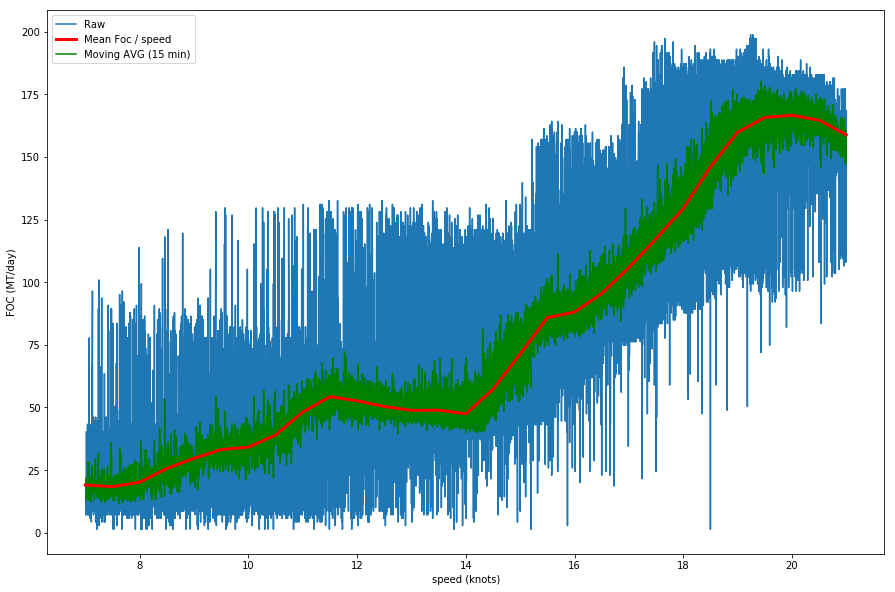

In [32]:
fig, ax1 = plt.subplots(figsize=(15,10))
trDataPLot = trData[trData[:, 3].argsort()].astype(float)
raw =  np.array([k for k in trDataPLot if   float(k[2])>=0 and float(k[4])>=0 and float(k[3])>7 and float(k[3])<=21 and float(k[5])>0  ])

i=7
maxSpeed = 21
sizesSpeed=[]
speed=[]
avgActualFoc=[]
while i <= maxSpeed:
        # workbook._sheets[sheet].insert_rows(k+27)

        speedArray = np.array([k for k in raw if float(k[3]) >= i-0.25 and float(k[3]) <= i + 0.25])

        if speedArray.__len__() > 1:
            sizesSpeed.append(speedArray.__len__())
            speed.append(i )
            avgActualFoc.append(np.mean(speedArray[:, 5]))
        i += 0.5


plt.plot(raw[:,3],raw[:,5],label='Raw',)
plt.plot(speed, avgActualFoc, label='Mean Foc / speed',lw=3,zorder=20,color='red')

plt.xlabel('speed (knots)')
plt.ylabel('FOC (MT/day)')

for i in range(0, len(trDataPLot)):
        trDataPLot[i] = np.mean(trDataPLot[i:i + 15], axis=0)

movingAvg = np.array([k for k in trDataPLot if   float(k[2])>=0 and float(k[4])>=0 and float(k[3])>7 and float(k[3])<=21 and float(k[5])>0  ])
#movingAvg = movingAvg[movingAvg[:, 3].argsort()]

plt.plot(movingAvg[:, 3], movingAvg[:, 5],label='Moving AVG (15 min)',color='green')
plt.legend()
plt.show()

### Model Architecture

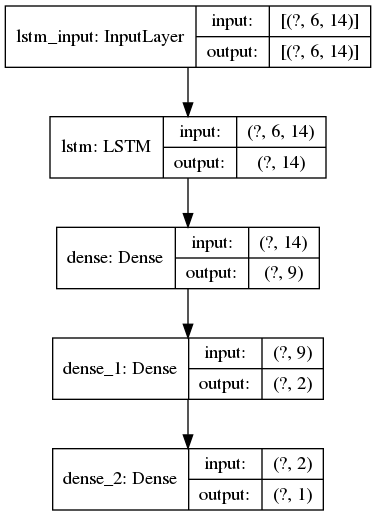

In [4]:
Image( filename='./neural.png')

### Model Convergence

#### With moving avg rolling window /  Without Input vector expansion

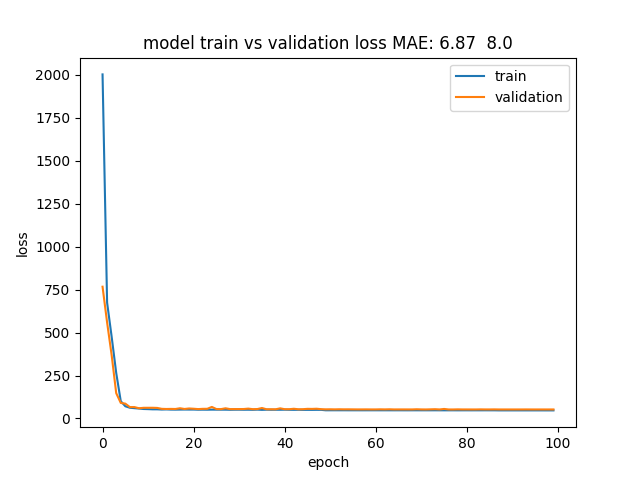

In [20]:
Image(filename='./withoutEnrichment.png') 

#### With moving avg rolling window /  With Input vector expansion

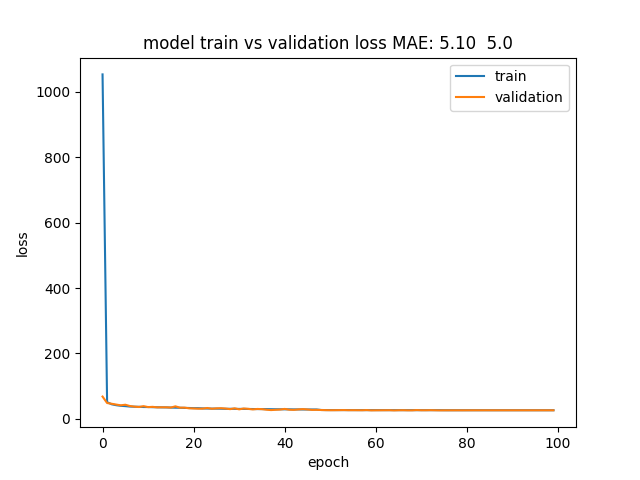

In [41]:
Image(filename='./withEnrichment.png') 

### Input vector expansion without weight regularizers && ReduceLROnPlateau  LR optimization

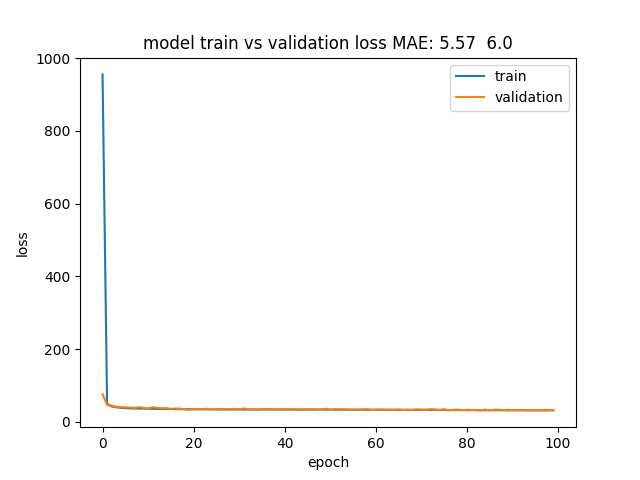

In [42]:
Image(filename='./withoutRegularizersRL.png') 

 ### Input vector expansion with weight regularizers && ReduceLROnPlateau  LR optimization

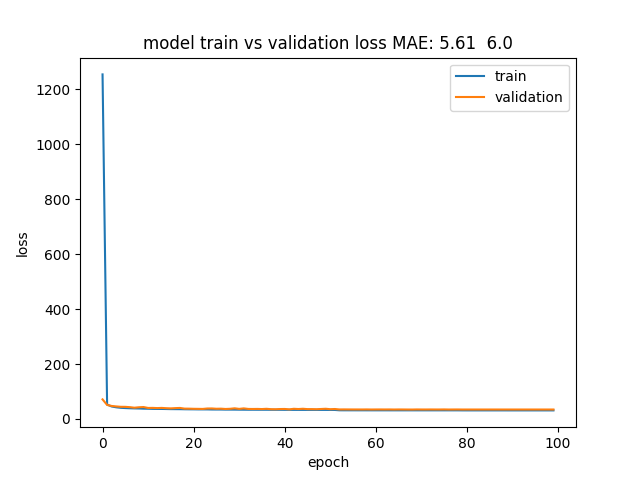

In [44]:
Image(filename='./withRegularizersRL.png') 

## Without  moving avg

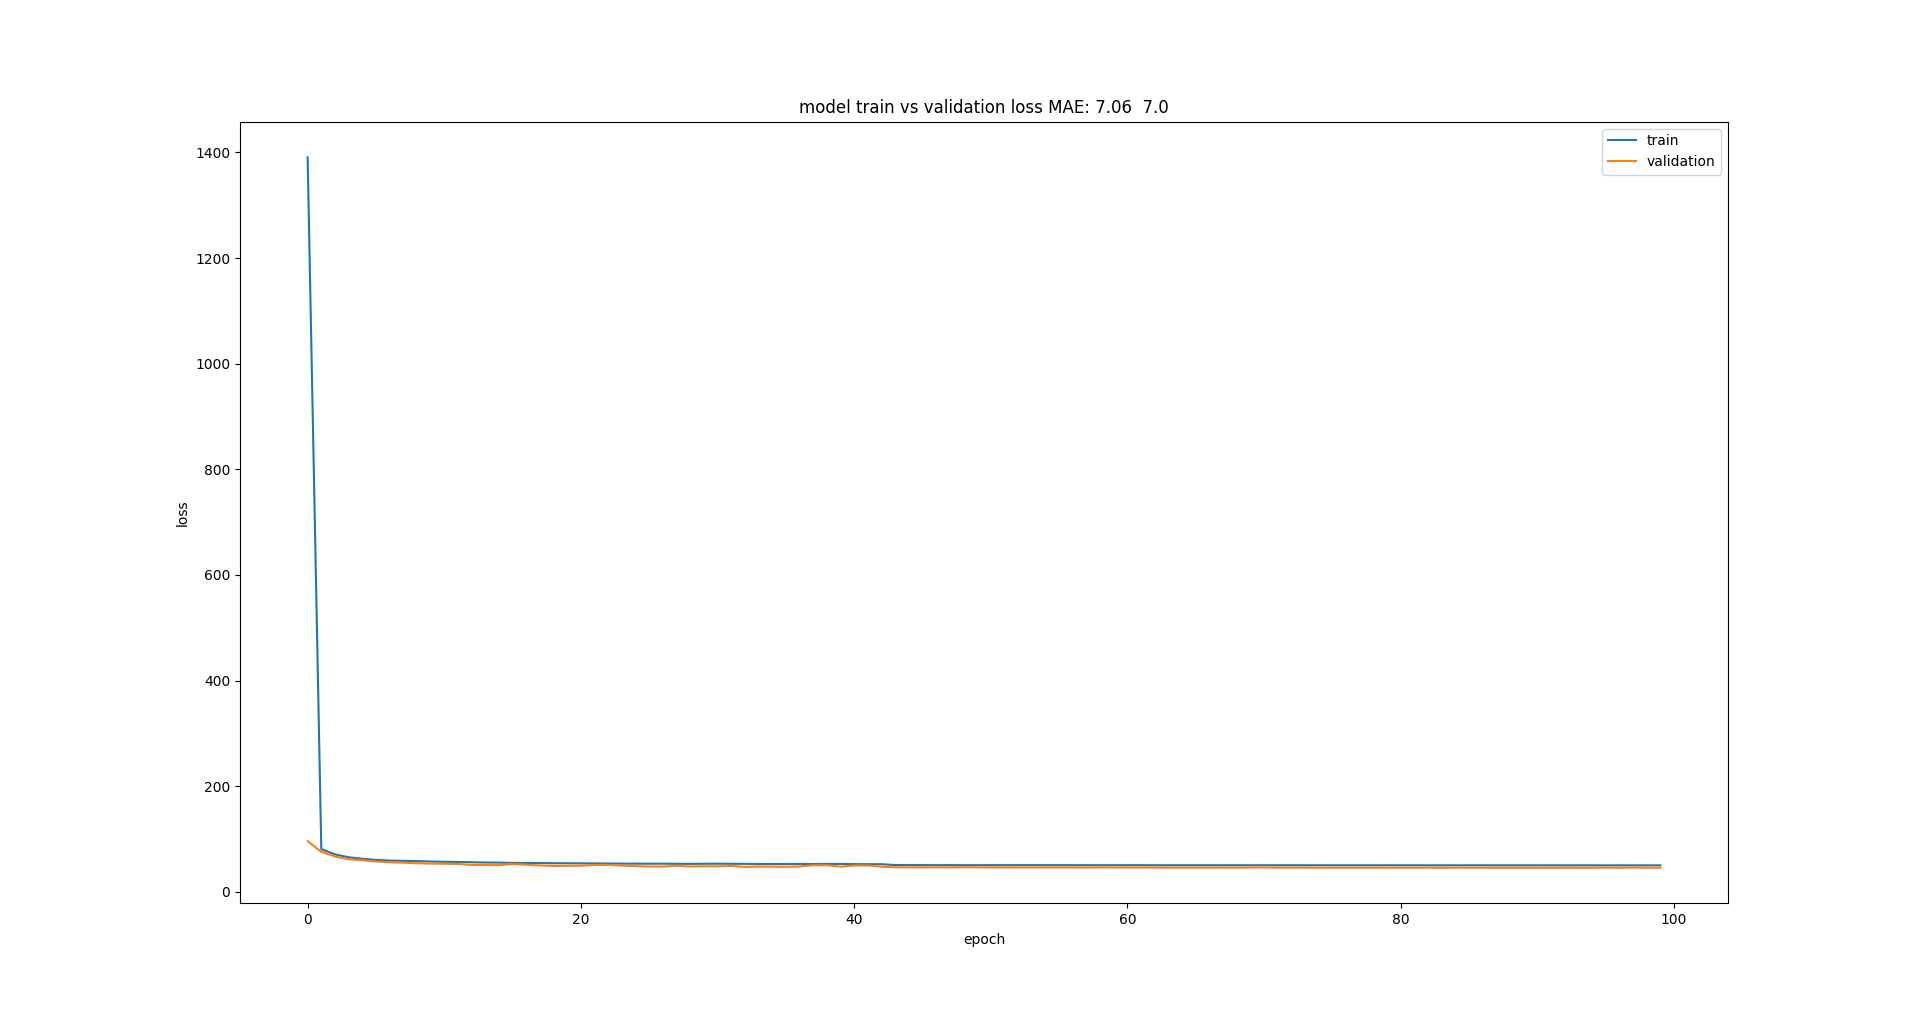

In [56]:
Image(filename='./withoutMovingAVG.png') 